# Simple Linear Model using Tensorflow
by Teppei Suzuki

## Contents
* Introduction
* Setup
* Examining the Data
* Building the Graph
* Cost Function
* Optimization
* Performance Measure
* Training
* Summary



## Introduction

In this notebook, we will build a simple linear model and train it on MNIST image dataset to achieve %x accuracy. We will be using Python along with Tensorflow, an open source library for Machine Learning!

## Setup

Let's first import some useful libraries along with tensorflow. Note that the general convention for importing tensorflow is to import as tf.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

C:\Users\tep\Anaconda3\envs\untitled1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's now load the sample MNIST dataset.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [18]:
img_row, img_col = 28, 28
img_shape = (img_row, img_col)
img_flat = img_row * img_col
num_classes = 10

## Examining the Data

Now that we have loaded the data, let's examine the contents to get a better understanding of what we are dealing with. As you can see, the data consists of training set and test set.

The training set is used solely for training the model. After the training is over, the test set is used to measure the accuracy of the trained model. Note that it is important to not use the test set for training.

In [16]:
print("Training-set:", len(data.train.labels))
print("Test-set:", len(data.test.labels))

Training-set: 55000
Test-set: 10000


Here we look at the first element in the training labels and training images. Notice that the size of the label is 10 (for 10 digit classification). The index where 1 is at is the correct value of the image. So for the printed example below, it is classifed as an 0.


In [68]:
print(data.train.labels[0])
print(data.train.images[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

In [14]:
print('size of a label:', len(data.train.labels[0]))
print('size of a data:', len(data.train.images[0]))

size of a label: 10
size of a data: 784


Lets plot some random images to see what they look like.

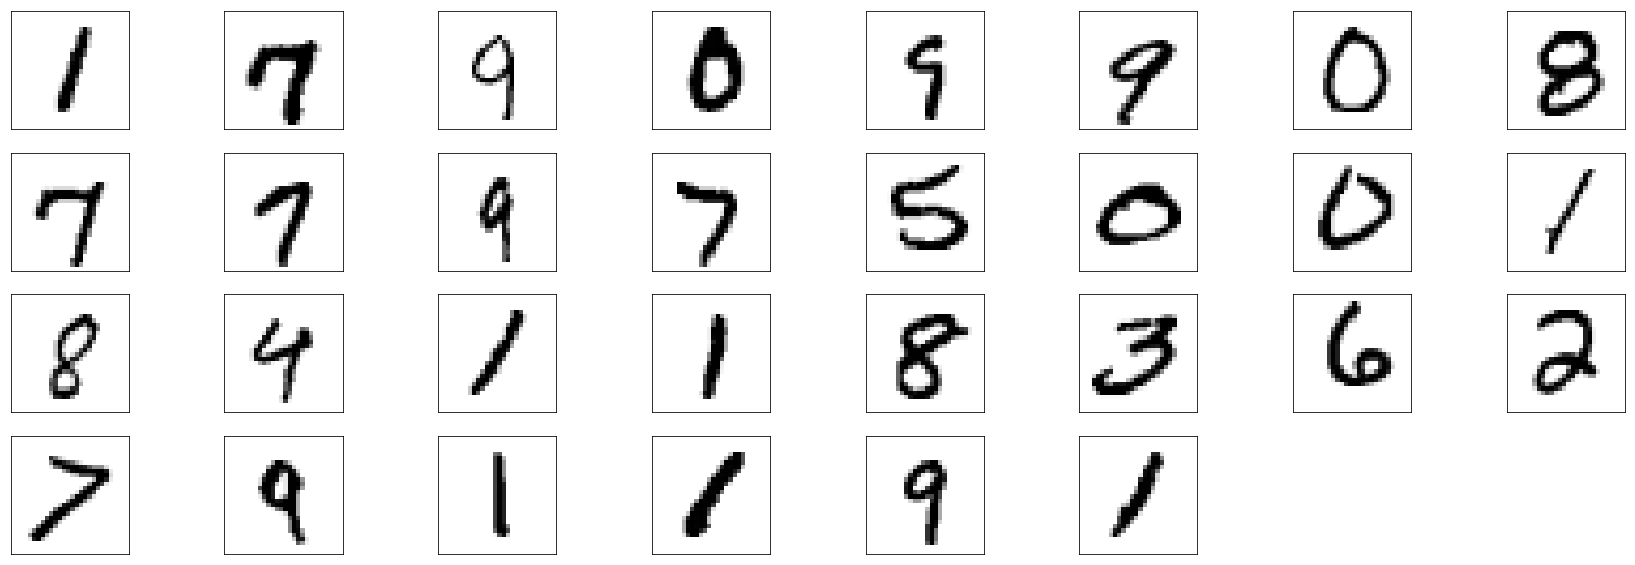

In [58]:
def plotRandomImages(data, num):
    # create a list with random ints of size num in the range(55000)
    random = np.random.randint(0, len(data.train.labels), size=num)
    
    # list of images
    images = []
    
    # add images to the list of images using the random ints
    # we have to reshape the array to 28x28 for correct plotting
    for i in range(num):
        index = random[i]
        images += [data.train.images[index].reshape(img_shape)]
    
    # plot the images
    plt.figure(figsize=(30,10))
    columns = 8
    
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image, cmap='binary')


plotRandomImages(data, 30)

## Building the Graph

We now create a placeholder so that the graph can have inputs. 

In [79]:
x = tf.placeholder(tf.float32, [None, img_flat])
y_one_hot = tf.placeholder(tf.float32, [None, num_classes])
y_true = tf.placeholder(tf.int64, [None])

We can not create variables that can be tuned during our training phase.

In [80]:
W = tf.Variable(tf.zeros([img_flat, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

Lets put the placeholders and variables to create the linear model.

In [81]:
logits = tf.matmul(x, W) + b

Since we want our values to act as probability, we apply softmax function to logits

In [82]:
y_pred_one_hot = tf.nn.softmax(logits)

We then search through the columns of each row to find the index of max value.
The index is the predicted value

In [83]:
y_pred = tf.argmax(y_pred_one_hot, axis=1)

### Cost Function

We now define the cost function.

In [90]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)

cost = tf.reduce_mean(cross_entropy)

### Optimization

In [91]:
# We use gradient decent for our optimization method
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

### Performance measure

In [92]:
correct_prediction = tf.equal(y_pred, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

We are now ready to start training our model!

In [93]:
session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)

In [122]:
num_iterations = 100000
batch_size = 100

In [123]:
for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        feed_dict_train = {x: x_batch,
                           y_one_hot: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

In [120]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

feed_dict_test = {x: data.test.images,
                  y_one_hot: data.test.labels,
                  y_true: data.test.cls}

In [124]:
# Use TensorFlow to compute the accuracy.
acc = session.run(accuracy, feed_dict=feed_dict_test)
    
print("Accuracy on test-set: {0:.1%}".format(acc))

Accuracy on test-set: 92.4%
